In [1]:
# Imports
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import transforms
import sys
from __future__ import division

### 1. (30pts) Define functions

In [2]:
# One hot Encoding the categorical output values to binary by adding 1's for that index and 0's otherwise
def oneHotEncode(y):
    enc = pd.get_dummies(y['y'])
    return np.matrix(enc)

# Applying Sigmoid Activation function to the hidden layer outputs used while forward propagation
# works with scalar, arrays and matrix as well
# Purpose of this method is to do squishing on the linear function
def sigmoid(z):
    return 1./(1+np.exp(-z))

# Applying Sigmoid Activation function to the hidden layer outputs used while backward propagation to get gradients
# works with scalar, arrays and matrix as well
# Purpose of this method is to do undo the squishing on the linear function
def sigmoid_prime(z):
    inv = (np.exp(-z))/(np.power((1+np.exp(-z)),2))
    return inv

def relu(z):
    return np.maximum(z,0)
    
def relu_prime(z):
    return np.where(z < 0, 0.0, 1.0)

# Get the loss of for the training example
def get_cost(Y, Yhat, lamda, Wl):
    m= Y.shape[1]
    loss = np.multiply(np.log(Yhat),Y) + np.multiply((1.-Y), np.log(1. - Yhat))
    loss = np.sum(loss)
    cost = -1./m * np.sum(loss) + ((lamda/(2*m)) * np.sum(np.square(Wl)))
    cost = np.squeeze(cost)
    return cost

# Forward propagation to calculate yHat by applying activation function twice
def forward_propagate(cache, layerCount, activationFuncs):
    for l in range(1, layerCount+1):
        Zl =  'Z' + str(l)
        Al =  'A' + str(l)
        Wl =  'W' + str(l)
        Al1 = 'A' + str(l-1)
        bl =  'b' + str(l)
        cache[Zl] = np.dot(cache[Wl], cache[Al1]) + cache[bl]
        activationFunc = activationFuncs[l] + '(cache[Zl])'
        cache[Al] = eval(activationFunc)
    return cache

# Backward Propagation function to calculate the gradients
def back_propagate(cache, layerCount, deactivationFuncs):
    gradients = {}
    m = cache['A0'].shape[1]
    for l in xrange(layerCount, 0, -1):
        if(l==layerCount): # is last layer
            dZl = cache['A' + str(l)] - cache['A' + str(l+1)]    
        else:
            Zl = 'Z'+ str(l)
            dZl1 = 'dZ'+str(l+1)
            deacFunc = deactivationFuncs[l] + '(cache[Zl])'
            actv_prime = eval(deacFunc)
            term1 = cache['W'+str(l+1)].T
            term2 = gradients[dZl1]
            product = np.dot( term1, term2)
            dZl = np.multiply(product, actv_prime) 
        gradients['dZ' + str(l)] = dZl
        Al1 = cache['A' + str(l-1)]
#         print('--dZ'+str(l))
#         print(dZl.shape)
#         print('A'+str(l-1))
#         print( Al1.shape)
        dWl = (1./m) * np.dot(dZl, Al1.T)
        dbl = (1./m) * np.sum(dZl, axis=1)
#         print('dW' +str(l))
#         print(dWl.shape)
#         print('db' +str(l))
#         print(dbl.shape)
        gradients['dW' + str(l)] = dWl
        gradients['db' + str(l)] = dbl
    return gradients  


def gradientDescent(X, Y, YOrg, alpha, iters, hiddenLayers, layerSizes, activationFuncs, deactivationFuncs, lamda, Xtest, Ytest):  
    
    cache = initialize_parameters(hiddenLayers, layerSizes,activationFuncs )
    cache['A0'] = X
    ykey = 'A' + str(hiddenLayers+1)
    cache[ykey] = Y
    old_cost = sys.maxsize
    new_cost = sys.maxsize
    cost_history = []
    maxTestAcc = -sys.maxsize -1
    for i in range(iters):
        # Call Forward propagation to calculate yHat
        cache = forward_propagate(cache, hiddenLayers, activationFuncs)
        old_cost = new_cost
        Afinal = cache['A'+str(hiddenLayers)]
        new_cost = get_cost(Y, cache['A'+str(hiddenLayers)], lamda, cache['W'+str(hiddenLayers)]) # Regularization
        gradients = back_propagate(cache, hiddenLayers, deactivationFuncs)
        for l in range(1,hiddenLayers+1):
            Wl = cache['W'+str(l)]
            gradients['dW'+str(l)] = gradients['dW'+str(l)] + (lamda/m) * Wl  # Regularization
            Wl = Wl - alpha * gradients['dW'+str(l)]
            cache['W'+str(l)] = Wl
            bl = cache['b'+str(l)]
            bl = bl - alpha * gradients['db'+str(l)]
            cache['b'+str(l)] = bl
        if(abs(old_cost - new_cost) < 0.00000000001):
            print("breaking" + str(old_cost) + str(new_cost))
            break;
        if(i%10 ==0):
            testcache = cache.copy()
            testcache['A0'] = Xtest
            ykey = 'A' + str(hiddenLayers+1)
            cache2 = forward_propagate(testcache, hiddenLayers, activationFuncs)
            ATestfinal = softmax(cache2['A'+str(hiddenLayers)])
            acc = get_accuracy(Ytest, ATestfinal)
            maxTestAcc = max(maxTestAcc, acc)
            print ("cost : " + str(new_cost) + " Test Accuracy : " + str(acc) + " Iteration: " + str(i))
        cost_history.append(new_cost)
    Afinal = softmax(Afinal) # Apply softmax to get the actual labels
    cache['A'+str(hiddenLayers)] = Afinal
    accuracy = get_accuracy(YOrg, Afinal)
    print("Maximum test accuracy is " + str(maxTestAcc))
    return cache, cost_history, new_cost, accuracy

# Softmax activation function to get the probablity of the classes
def softmax(z):
    softMax = (np.exp(z) / np.sum(np.exp(z),axis=0))
    softMax = np.matrix(np.argmax(softMax,axis=0)).T
    return softMax

def plotCostHistory(cost_history, alpha, i):
     line = plt.plot(cost_history, label=alpha)
     plt.ylabel('Cost');
     plt.ylim( (0, 4) )
     plt.xlabel('Iterations');
     plt.title('Cost Progression with Iterations for different learning rates')
     plt.legend()
        
def get_accuracy(Y, Ypred):
    Y = np.matrix(Y)
    numcorrect = 0
    for (x,y) in zip(Ypred,Y):
        if(x[0]==y[0]):
            numcorrect+=1
    accuracy=numcorrect*100.0/len(Y)
    return accuracy

### 2. Split data

In [3]:
# Reading the training data
data_train = pd.read_csv('exam1_train.csv', sep=",", encoding='utf-8', header='infer')
# Remove the un-necessary column
df_train = data_train.drop('Unnamed: 0',axis=1)
m = df_train.shape[0]

y_train = pd.DataFrame(df_train['y'])
X_train = df_train.drop(['y'], axis=1)

X_train_mat = np.matrix(X_train).T
y_train_mat = oneHotEncode(y_train).T

     y
202  4


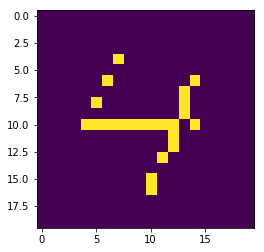

In [4]:
# Reading the test data
data_test = pd.read_csv('exam1_test.csv', sep=",", encoding='utf-8', header='infer')
# Remove the un-necessary column
df_test = data_test.drop('Unnamed: 0',axis=1)

y_test = pd.DataFrame(df_test['y'])
X_test = df_test.drop(['y'], axis=1)

X_test_mat = np.matrix(X_test).T
y_test_mat = oneHotEncode(y_test).T

# Plot the selected pixel
num = 202
pixels = np.array(X_test[num:num+1], dtype='uint8')
print(y_test[num:num+1])
pixels = pixels.reshape((20, 20)).T
plt.imshow(pixels)
plt.show()

### 3. (10pts) Initialize parameters

In [5]:
# Initialize weights // TODO - change the initialization method

np.random.seed(1) # Setting random seed to 1
def initialize_parameters(hiddenLayers, layerSizes, activationFuncs):
    cache = {}
    for l in range(1,hiddenLayers+1):
        #print(l)
        Wl = 'W' + str(l)
        bl = 'b' + str(l)
        #print(layerSizes[l])
        #print(layerSizes[l-1])
        print('activation is ' + str(activationFuncs[l]) + ' for layer ' + str(l))
        if(activationFuncs[l]=='sigmoid'):
            print('activation is sigmoid for layer ' + str(l))
            cache[Wl] =  np.random.randn(layerSizes[l], layerSizes[l-1]) * np.sqrt(2./layerSizes[l-1])
            cache[bl] =  np.zeros((layerSizes[l],1))
        elif(activationFuncs[l]=='relu'):
            print('activation is relu for layer ' + str(l))
            cache[Wl] =  np.random.randn(layerSizes[l], layerSizes[l-1]) * (2./np.sqrt(layerSizes[l-1]))
            cache[bl] =  np.zeros((layerSizes[l],1))
        else:
            print('activation is random for layer ' + str(l))
            cache[Wl] =  np.random.randn(layerSizes[l], layerSizes[l-1]) * 0.01 ## Random
            cache[bl] =  np.zeros((layerSizes[l],1))
        l=l+1
    #print(cache)
    return cache

### 4. (30pts) Deep Neural Network model with more than 2 hidden layers

In [6]:
# Defining Hyperparameters
hiddenLayers = 3
layerSizes = [400, 100, 40, 10] # As specified in assignment requirements, can have as many hidden layers
print(" Number of hidden layers including output layer are - " + str(hiddenLayers))
activationFuncs = ['', 'relu', 'relu', 'sigmoid']
deactivationFuncs = ['', 'relu_prime', 'relu_prime', 'sigmoid_prime']

 Number of hidden layers including output layer are - 3


In [7]:
# cache = initialize_parameters(hiddenLayers, layerSizes, activationFuncs)
# print(cache['W1'].shape)
# # print(cache['W2'].shape)
# # print(cache['W3'].shape)
# # print(cache['b1'].shape)
# # print(cache['b2'].shape)
# # print(cache['b3'].shape)
# cache['A0'] = X_train_mat
# ykey = 'A' + str(len(layerSizes))
# cache[ykey] = y_train_mat
# cache = forward_propagate(cache, hiddenLayers, ['', 'apply_sigmoid', 'apply_sigmoid','apply_sigmoid'])
# # print(cache['A1'])
# # print(cache['A2'])
# # print(cache['A3'])
# # print(cache['Z2'])

In [8]:
# gradients = back_propagate(cache, hiddenLayers, deactivationFuncs)

### 5. (10pts) Predictions

### 6. (20pts) Optimization

In [ ]:
# Optimization function to check cost propagartion for different learning rates
def optimize():
    lamdas = [14.0]
    alpha = [0.3,0.4,0.5,0.6]
    i=0
    scores = pd.DataFrame(columns=['alpha','cache','accuracy', 'lamda'])
    print('*****************Training Data*********************')
    for l in lamdas:
        for a in alpha:
            cache, cost_history, new_cost, acc = gradientDescent(X_train_mat, y_train_mat, y_train, a, 15000, 
                                                hiddenLayers, layerSizes, activationFuncs, deactivationFuncs, l, X_test_mat, y_test)
            scores.loc[i] = pd.Series({'alpha':a, 'cache': cache, 'accuracy':acc, 'lamda':l})
            print("Cost with " + "Alpha " + str(a) + " and lambda " + str(l) + " is " + str(new_cost) + " & " + "Accuracy is " + str(acc) + " %")
            plotCostHistory(cost_history, a, i)
            i+=1
        least_cost_comb = scores['accuracy'].idxmax()
        alph = scores.iloc[[least_cost_comb]]['alpha'][least_cost_comb]
        cache = scores.iloc[[least_cost_comb]]['cache'][least_cost_comb]
        plt.show()
        print('Best alpha is ' + str(alph))
    return cache, alph,scores

In [ ]:
# Get the best combination of weights and alpha
cache, alph,scores = optimize()

*****************Training Data*********************
activation is relu for layer 1
activation is relu for layer 1
activation is relu for layer 2
activation is relu for layer 2
activation is sigmoid for layer 3
activation is sigmoid for layer 3
cost : 8.32843109401 Test Accuracy : 10.7333333333 Iteration: 0
cost : 2.98364050691 Test Accuracy : 51.5333333333 Iteration: 10
cost : 1.88824945209 Test Accuracy : 72.2 Iteration: 20
cost : 1.95258757419 Test Accuracy : 71.1333333333 Iteration: 30
cost : 1.20393569582 Test Accuracy : 80.6666666667 Iteration: 40
cost : 0.995012783609 Test Accuracy : 84.0666666667 Iteration: 50
cost : 0.935227227517 Test Accuracy : 84.0 Iteration: 60
cost : 0.835637293229 Test Accuracy : 84.5333333333 Iteration: 70
cost : 0.722066096967 Test Accuracy : 87.6666666667 Iteration: 80
cost : 0.690261785726 Test Accuracy : 87.7333333333 Iteration: 90
cost : 0.664105014915 Test Accuracy : 88.9333333333 Iteration: 100
cost : 0.605895544986 Test Accuracy : 90.0666666667 I

cost : 0.247723050792 Test Accuracy : 93.6666666667 Iteration: 1250
cost : 0.249470469471 Test Accuracy : 93.7333333333 Iteration: 1260
cost : 0.254035887123 Test Accuracy : 93.8 Iteration: 1270
cost : 0.254802343815 Test Accuracy : 93.8 Iteration: 1280
cost : 0.247211980123 Test Accuracy : 93.6666666667 Iteration: 1290
cost : 0.245957814459 Test Accuracy : 93.5333333333 Iteration: 1300
cost : 0.246791474364 Test Accuracy : 93.3333333333 Iteration: 1310
cost : 0.24941037591 Test Accuracy : 93.1333333333 Iteration: 1320
cost : 0.253630113167 Test Accuracy : 93.2 Iteration: 1330
cost : 0.25814712784 Test Accuracy : 93.1333333333 Iteration: 1340
cost : 0.249055113718 Test Accuracy : 93.4666666667 Iteration: 1350
cost : 0.245758776281 Test Accuracy : 93.5333333333 Iteration: 1360
cost : 0.246885951787 Test Accuracy : 93.6 Iteration: 1370
cost : 0.248302741592 Test Accuracy : 93.6 Iteration: 1380
cost : 0.246158109982 Test Accuracy : 93.6 Iteration: 1390
cost : 0.243635713104 Test Accuracy 

cost : 0.228556225402 Test Accuracy : 93.6 Iteration: 2510
cost : 0.228680649074 Test Accuracy : 93.5333333333 Iteration: 2520
cost : 0.229430602194 Test Accuracy : 93.6 Iteration: 2530
cost : 0.229344531908 Test Accuracy : 93.6 Iteration: 2540
cost : 0.228570292547 Test Accuracy : 93.9333333333 Iteration: 2550
cost : 0.228456283409 Test Accuracy : 93.8666666667 Iteration: 2560
cost : 0.2292548684 Test Accuracy : 94.1333333333 Iteration: 2570
cost : 0.230643995227 Test Accuracy : 94.0666666667 Iteration: 2580
cost : 0.231630452212 Test Accuracy : 94.0 Iteration: 2590
cost : 0.230732405094 Test Accuracy : 94.0666666667 Iteration: 2600
cost : 0.228647433645 Test Accuracy : 94.1333333333 Iteration: 2610
cost : 0.228046356034 Test Accuracy : 94.2 Iteration: 2620
cost : 0.228644795308 Test Accuracy : 94.1333333333 Iteration: 2630
cost : 0.229283920403 Test Accuracy : 94.1333333333 Iteration: 2640
cost : 0.229286476215 Test Accuracy : 94.1333333333 Iteration: 2650
cost : 0.228922999579 Test 

cost : 0.222126563992 Test Accuracy : 94.0 Iteration: 3780
cost : 0.224372215145 Test Accuracy : 93.8 Iteration: 3790
cost : 0.230606970483 Test Accuracy : 93.8666666667 Iteration: 3800
cost : 0.258842663254 Test Accuracy : 93.3333333333 Iteration: 3810
cost : 1.36526656577 Test Accuracy : 83.6 Iteration: 3820
cost : 0.555784798653 Test Accuracy : 91.0 Iteration: 3830
cost : 0.421902876611 Test Accuracy : 91.7333333333 Iteration: 3840
cost : 0.374783846516 Test Accuracy : 92.6 Iteration: 3850
cost : 0.347646033392 Test Accuracy : 93.0 Iteration: 3860
cost : 0.32852617747 Test Accuracy : 93.0666666667 Iteration: 3870
cost : 0.314308494155 Test Accuracy : 93.4 Iteration: 3880
cost : 0.30327343665 Test Accuracy : 93.4666666667 Iteration: 3890
cost : 0.293782695702 Test Accuracy : 93.5333333333 Iteration: 3900
cost : 0.285871288739 Test Accuracy : 93.5333333333 Iteration: 3910
cost : 0.27920054603 Test Accuracy : 93.8 Iteration: 3920
cost : 0.273970784608 Test Accuracy : 93.7333333333 Iter

cost : 0.222959066605 Test Accuracy : 94.2 Iteration: 5050
cost : 0.22159314085 Test Accuracy : 94.0666666667 Iteration: 5060
cost : 0.221271422621 Test Accuracy : 94.0 Iteration: 5070
cost : 0.221392906756 Test Accuracy : 94.0 Iteration: 5080
cost : 0.221870883139 Test Accuracy : 94.1333333333 Iteration: 5090
cost : 0.222663775468 Test Accuracy : 94.2 Iteration: 5100
cost : 0.223567314236 Test Accuracy : 94.3333333333 Iteration: 5110
cost : 0.223083996786 Test Accuracy : 94.2666666667 Iteration: 5120
cost : 0.221343833843 Test Accuracy : 94.2 Iteration: 5130
cost : 0.220522559328 Test Accuracy : 94.0666666667 Iteration: 5140
cost : 0.220542800178 Test Accuracy : 94.1333333333 Iteration: 5150
cost : 0.221664748569 Test Accuracy : 94.2666666667 Iteration: 5160
cost : 0.222480246448 Test Accuracy : 94.3333333333 Iteration: 5170
cost : 0.222894307943 Test Accuracy : 94.2666666667 Iteration: 5180
cost : 0.222378568603 Test Accuracy : 94.1333333333 Iteration: 5190
cost : 0.220995312327 Test

cost : 0.24505436219 Test Accuracy : 94.2 Iteration: 6310
cost : 0.244467791389 Test Accuracy : 94.2 Iteration: 6320
cost : 0.243231088471 Test Accuracy : 94.2 Iteration: 6330
cost : 0.242198319467 Test Accuracy : 94.1333333333 Iteration: 6340
cost : 0.241656445845 Test Accuracy : 94.0666666667 Iteration: 6350
cost : 0.241574381085 Test Accuracy : 94.1333333333 Iteration: 6360
cost : 0.241950083355 Test Accuracy : 94.2666666667 Iteration: 6370
cost : 0.241507100111 Test Accuracy : 94.2666666667 Iteration: 6380
cost : 0.240535168336 Test Accuracy : 94.2666666667 Iteration: 6390
cost : 0.239712260799 Test Accuracy : 94.2 Iteration: 6400
cost : 0.23914596606 Test Accuracy : 94.2 Iteration: 6410
cost : 0.239222841157 Test Accuracy : 94.2666666667 Iteration: 6420
cost : 0.240249863676 Test Accuracy : 94.3333333333 Iteration: 6430
cost : 0.239700876974 Test Accuracy : 94.2666666667 Iteration: 6440
cost : 0.237974037282 Test Accuracy : 94.2666666667 Iteration: 6450
cost : 0.236951123459 Test 

cost : 0.240781225394 Test Accuracy : 93.5333333333 Iteration: 7570
cost : 0.920841304085 Test Accuracy : 91.0 Iteration: 7580
cost : 0.281758343669 Test Accuracy : 93.4 Iteration: 7590
cost : 0.250127578694 Test Accuracy : 93.3333333333 Iteration: 7600
cost : 0.237615191912 Test Accuracy : 93.5333333333 Iteration: 7610
cost : 0.231586312781 Test Accuracy : 93.6 Iteration: 7620
cost : 0.227931242483 Test Accuracy : 93.6 Iteration: 7630
cost : 0.225650722559 Test Accuracy : 93.7333333333 Iteration: 7640
cost : 0.224198805841 Test Accuracy : 93.8 Iteration: 7650
cost : 0.22322342196 Test Accuracy : 93.8 Iteration: 7660
cost : 0.222524911594 Test Accuracy : 93.9333333333 Iteration: 7670
cost : 0.221981819391 Test Accuracy : 94.0 Iteration: 7680
cost : 0.221571246408 Test Accuracy : 94.2 Iteration: 7690
cost : 0.221229739557 Test Accuracy : 94.2 Iteration: 7700
cost : 0.220933386649 Test Accuracy : 94.2666666667 Iteration: 7710
cost : 0.220536058665 Test Accuracy : 94.2666666667 Iteration:

cost : 0.219884968065 Test Accuracy : 94.2 Iteration: 8830
cost : 0.217554863711 Test Accuracy : 94.4666666667 Iteration: 8840
cost : 0.216866939334 Test Accuracy : 94.3333333333 Iteration: 8850
cost : 0.21686591694 Test Accuracy : 94.2 Iteration: 8860
cost : 0.21761894928 Test Accuracy : 94.2666666667 Iteration: 8870
cost : 0.218437836126 Test Accuracy : 94.0666666667 Iteration: 8880
cost : 0.219305468416 Test Accuracy : 94.2666666667 Iteration: 8890
cost : 0.221931725737 Test Accuracy : 94.4666666667 Iteration: 8900
cost : 0.223192920519 Test Accuracy : 94.4 Iteration: 8910
cost : 0.219871133729 Test Accuracy : 94.5333333333 Iteration: 8920
cost : 0.217897680863 Test Accuracy : 94.2 Iteration: 8930
cost : 0.217252084511 Test Accuracy : 94.2666666667 Iteration: 8940
cost : 0.21711983327 Test Accuracy : 94.2666666667 Iteration: 8950
cost : 0.217955565809 Test Accuracy : 94.4 Iteration: 8960
cost : 0.221508394307 Test Accuracy : 94.4 Iteration: 8970
cost : 0.225501608624 Test Accuracy :

cost : 0.265188298341 Test Accuracy : 92.7333333333 Iteration: 10080
cost : 0.263652957955 Test Accuracy : 92.6666666667 Iteration: 10090
cost : 0.262577250285 Test Accuracy : 92.6666666667 Iteration: 10100
cost : 0.261612330888 Test Accuracy : 92.6666666667 Iteration: 10110
cost : 0.260731083812 Test Accuracy : 92.7333333333 Iteration: 10120
cost : 0.25922045069 Test Accuracy : 92.6666666667 Iteration: 10130
cost : 0.257848918347 Test Accuracy : 92.6666666667 Iteration: 10140
cost : 0.256943141322 Test Accuracy : 92.6666666667 Iteration: 10150
cost : 0.256306281528 Test Accuracy : 92.8 Iteration: 10160
cost : 0.255281930934 Test Accuracy : 92.8 Iteration: 10170
cost : 0.253974090628 Test Accuracy : 92.8666666667 Iteration: 10180
cost : 0.252928239237 Test Accuracy : 92.8 Iteration: 10190
cost : 0.252402205478 Test Accuracy : 92.7333333333 Iteration: 10200
cost : 0.251584476901 Test Accuracy : 92.8666666667 Iteration: 10210
cost : 0.250501357043 Test Accuracy : 92.8 Iteration: 10220
co

cost : 0.225990294449 Test Accuracy : 92.9333333333 Iteration: 11320
cost : 0.225768646878 Test Accuracy : 93.0 Iteration: 11330
cost : 0.226922013218 Test Accuracy : 92.7333333333 Iteration: 11340
cost : 0.228081343225 Test Accuracy : 92.8 Iteration: 11350
cost : 0.227348485675 Test Accuracy : 92.8 Iteration: 11360
cost : 0.226057779469 Test Accuracy : 92.9333333333 Iteration: 11370
cost : 0.22580587057 Test Accuracy : 93.0 Iteration: 11380
cost : 0.226222437583 Test Accuracy : 93.1333333333 Iteration: 11390
cost : 0.226172591116 Test Accuracy : 93.0666666667 Iteration: 11400
cost : 0.226969978503 Test Accuracy : 92.9333333333 Iteration: 11410
cost : 0.227696313976 Test Accuracy : 92.9333333333 Iteration: 11420
cost : 0.226489284715 Test Accuracy : 92.8 Iteration: 11430
cost : 0.225393126647 Test Accuracy : 92.8666666667 Iteration: 11440
cost : 0.225212343465 Test Accuracy : 93.0 Iteration: 11450
cost : 0.225367915331 Test Accuracy : 93.0 Iteration: 11460
cost : 0.225522674104 Test Ac

cost : 0.222854515664 Test Accuracy : 93.2 Iteration: 12560
cost : 0.225244340111 Test Accuracy : 93.0666666667 Iteration: 12570
cost : 0.224593863707 Test Accuracy : 93.0666666667 Iteration: 12580
cost : 0.221461687337 Test Accuracy : 93.2 Iteration: 12590
cost : 0.220224479338 Test Accuracy : 93.4 Iteration: 12600
cost : 0.220550185391 Test Accuracy : 93.4 Iteration: 12610
cost : 0.221202572454 Test Accuracy : 93.2 Iteration: 12620
cost : 0.221568816671 Test Accuracy : 93.2 Iteration: 12630
cost : 0.223384264142 Test Accuracy : 93.1333333333 Iteration: 12640
cost : 0.225073439598 Test Accuracy : 93.2 Iteration: 12650
cost : 0.223583919306 Test Accuracy : 93.1333333333 Iteration: 12660
cost : 0.22089274485 Test Accuracy : 93.1333333333 Iteration: 12670
cost : 0.220210217968 Test Accuracy : 93.1333333333 Iteration: 12680
cost : 0.220088911347 Test Accuracy : 93.0666666667 Iteration: 12690
cost : 0.22080009447 Test Accuracy : 93.1333333333 Iteration: 12700
cost : 0.222259448721 Test Acc

cost : 0.219168455845 Test Accuracy : 93.2 Iteration: 13810
cost : 0.217620750725 Test Accuracy : 93.4 Iteration: 13820
cost : 0.217201587723 Test Accuracy : 93.3333333333 Iteration: 13830
cost : 0.217589348004 Test Accuracy : 93.3333333333 Iteration: 13840
cost : 0.218499010057 Test Accuracy : 93.3333333333 Iteration: 13850
cost : 0.21949459047 Test Accuracy : 93.2 Iteration: 13860
cost : 0.222692370913 Test Accuracy : 93.1333333333 Iteration: 13870
cost : 0.226374964684 Test Accuracy : 93.1333333333 Iteration: 13880
cost : 0.22134747051 Test Accuracy : 93.2 Iteration: 13890
cost : 0.21746121101 Test Accuracy : 93.2 Iteration: 13900
cost : 0.216950725304 Test Accuracy : 93.4 Iteration: 13910
cost : 0.217344566138 Test Accuracy : 93.2666666667 Iteration: 13920
cost : 0.218575569639 Test Accuracy : 93.2666666667 Iteration: 13930
cost : 0.220615003233 Test Accuracy : 93.2666666667 Iteration: 13940
cost : 0.221701832967 Test Accuracy : 93.2666666667 Iteration: 13950
cost : 0.219703827097 

cost : 1.75814702272 Test Accuracy : 59.5333333333 Iteration: 20
cost : 1.39107422359 Test Accuracy : 78.4666666667 Iteration: 30
cost : 1.26967121548 Test Accuracy : 82.6666666667 Iteration: 40
cost : 1.05220294883 Test Accuracy : 82.6666666667 Iteration: 50
cost : 0.822235667296 Test Accuracy : 82.8666666667 Iteration: 60
cost : 0.707592891671 Test Accuracy : 86.7333333333 Iteration: 70
cost : 0.638008910545 Test Accuracy : 88.6666666667 Iteration: 80
cost : 0.587305439646 Test Accuracy : 89.4666666667 Iteration: 90
cost : 0.623438396101 Test Accuracy : 88.4 Iteration: 100
cost : 0.527311404093 Test Accuracy : 89.8666666667 Iteration: 110
cost : 0.495903133762 Test Accuracy : 90.2666666667 Iteration: 120
cost : 0.508589359699 Test Accuracy : 89.9333333333 Iteration: 130
cost : 0.493517695233 Test Accuracy : 90.2666666667 Iteration: 140
cost : 0.453950849278 Test Accuracy : 90.6666666667 Iteration: 150
cost : 0.515968178512 Test Accuracy : 89.2666666667 Iteration: 160
cost : 0.4281399

cost : 0.237452484381 Test Accuracy : 93.4666666667 Iteration: 1280
cost : 0.240826043716 Test Accuracy : 93.4666666667 Iteration: 1290
cost : 0.24816795187 Test Accuracy : 93.0666666667 Iteration: 1300
cost : 0.248792122586 Test Accuracy : 93.2666666667 Iteration: 1310
cost : 0.236155202934 Test Accuracy : 93.7333333333 Iteration: 1320
cost : 0.237601062502 Test Accuracy : 93.6666666667 Iteration: 1330
cost : 0.250738504923 Test Accuracy : 93.5333333333 Iteration: 1340
cost : 1.72790178224 Test Accuracy : 72.2 Iteration: 1350
cost : 0.631445156077 Test Accuracy : 91.1333333333 Iteration: 1360
cost : 0.533207203493 Test Accuracy : 91.2666666667 Iteration: 1370
cost : 0.341331278423 Test Accuracy : 92.4666666667 Iteration: 1380
cost : 0.314308662789 Test Accuracy : 92.8666666667 Iteration: 1390
cost : 0.298210307625 Test Accuracy : 93.0 Iteration: 1400
cost : 0.287549609185 Test Accuracy : 93.0666666667 Iteration: 1410
cost : 0.279986247319 Test Accuracy : 93.2 Iteration: 1420
cost : 0.

cost : 0.232182144804 Test Accuracy : 93.7333333333 Iteration: 2550
cost : 0.938064848722 Test Accuracy : 90.5333333333 Iteration: 2560
cost : 0.23974420615 Test Accuracy : 93.4 Iteration: 2570
cost : 0.228830053938 Test Accuracy : 93.5333333333 Iteration: 2580
cost : 0.224791668802 Test Accuracy : 93.4666666667 Iteration: 2590
cost : 0.223118904924 Test Accuracy : 93.4666666667 Iteration: 2600
cost : 0.222970804709 Test Accuracy : 93.6 Iteration: 2610
cost : 0.224594479398 Test Accuracy : 93.8666666667 Iteration: 2620
cost : 0.22651862552 Test Accuracy : 93.8 Iteration: 2630
cost : 0.225863262753 Test Accuracy : 93.7333333333 Iteration: 2640
cost : 0.223689608374 Test Accuracy : 93.7333333333 Iteration: 2650
cost : 0.223230925334 Test Accuracy : 93.7333333333 Iteration: 2660
cost : 0.224653992659 Test Accuracy : 93.8 Iteration: 2670
cost : 0.227888997266 Test Accuracy : 93.9333333333 Iteration: 2680
cost : 0.226390037914 Test Accuracy : 93.8 Iteration: 2690
cost : 0.222645785133 Test 

cost : 0.228252286574 Test Accuracy : 93.6666666667 Iteration: 3810
cost : 0.224229534254 Test Accuracy : 93.4666666667 Iteration: 3820
cost : 0.223592824095 Test Accuracy : 93.0666666667 Iteration: 3830
cost : 0.23033522962 Test Accuracy : 93.0666666667 Iteration: 3840
cost : 0.220729051271 Test Accuracy : 93.2 Iteration: 3850
cost : 0.216654361825 Test Accuracy : 93.9333333333 Iteration: 3860
cost : 0.216870033603 Test Accuracy : 93.9333333333 Iteration: 3870
cost : 0.218010426361 Test Accuracy : 93.7333333333 Iteration: 3880
cost : 0.219632020275 Test Accuracy : 93.2 Iteration: 3890
cost : 0.222619976838 Test Accuracy : 93.0666666667 Iteration: 3900
cost : 0.223929334732 Test Accuracy : 93.1333333333 Iteration: 3910
cost : 0.219932196983 Test Accuracy : 93.4666666667 Iteration: 3920
cost : 0.219357717127 Test Accuracy : 93.7333333333 Iteration: 3930
cost : 0.223870607169 Test Accuracy : 93.8 Iteration: 3940
cost : 0.244161565843 Test Accuracy : 93.1333333333 Iteration: 3950
cost : 2

cost : 0.233161555208 Test Accuracy : 93.8666666667 Iteration: 5080
cost : 0.232573665102 Test Accuracy : 93.8666666667 Iteration: 5090
cost : 0.23216812773 Test Accuracy : 93.8666666667 Iteration: 5100
cost : 0.231832763874 Test Accuracy : 93.8666666667 Iteration: 5110
cost : 0.231347819726 Test Accuracy : 93.8666666667 Iteration: 5120
cost : 0.230932946511 Test Accuracy : 93.8666666667 Iteration: 5130
cost : 0.23005068573 Test Accuracy : 93.8 Iteration: 5140
cost : 0.228049929498 Test Accuracy : 93.9333333333 Iteration: 5150
cost : 0.227017151498 Test Accuracy : 93.9333333333 Iteration: 5160
cost : 0.226469798465 Test Accuracy : 93.8666666667 Iteration: 5170
cost : 0.226959762746 Test Accuracy : 93.7333333333 Iteration: 5180
cost : 0.227560772009 Test Accuracy : 93.7333333333 Iteration: 5190
cost : 0.228396453716 Test Accuracy : 93.7333333333 Iteration: 5200
cost : 0.228930595099 Test Accuracy : 93.8666666667 Iteration: 5210
cost : 0.226965816676 Test Accuracy : 93.8 Iteration: 5220


cost : 0.22222335282 Test Accuracy : 93.3333333333 Iteration: 6340
cost : 0.220020625712 Test Accuracy : 93.5333333333 Iteration: 6350
cost : 0.218768773007 Test Accuracy : 93.6666666667 Iteration: 6360
cost : 0.218721816904 Test Accuracy : 93.6666666667 Iteration: 6370
cost : 0.220326949322 Test Accuracy : 93.4666666667 Iteration: 6380
cost : 0.223542853491 Test Accuracy : 93.2666666667 Iteration: 6390
cost : 0.223567859995 Test Accuracy : 93.3333333333 Iteration: 6400
cost : 0.219509702497 Test Accuracy : 93.6 Iteration: 6410
cost : 0.218439894022 Test Accuracy : 93.6666666667 Iteration: 6420
cost : 0.218816720228 Test Accuracy : 93.6 Iteration: 6430
cost : 0.220957869474 Test Accuracy : 93.2666666667 Iteration: 6440
cost : 0.226244303386 Test Accuracy : 93.2666666667 Iteration: 6450
cost : 0.233353013407 Test Accuracy : 93.1333333333 Iteration: 6460
cost : 0.223331574204 Test Accuracy : 93.4666666667 Iteration: 6470
cost : 0.220312452029 Test Accuracy : 93.9333333333 Iteration: 6480

cost : 0.224301364754 Test Accuracy : 94.0666666667 Iteration: 7600
cost : 0.221021981845 Test Accuracy : 94.2 Iteration: 7610
cost : 0.216647000549 Test Accuracy : 94.2666666667 Iteration: 7620
cost : 0.215203822517 Test Accuracy : 94.1333333333 Iteration: 7630
cost : 0.21543220364 Test Accuracy : 94.2 Iteration: 7640
cost : 0.216581456756 Test Accuracy : 94.2 Iteration: 7650
cost : 0.218105807164 Test Accuracy : 94.2666666667 Iteration: 7660
cost : 0.220019798355 Test Accuracy : 94.2666666667 Iteration: 7670
cost : 0.220680115093 Test Accuracy : 94.1333333333 Iteration: 7680
cost : 0.218626614996 Test Accuracy : 94.1333333333 Iteration: 7690
cost : 0.216161937557 Test Accuracy : 94.2 Iteration: 7700
cost : 0.216426170173 Test Accuracy : 94.1333333333 Iteration: 7710
cost : 0.217645245254 Test Accuracy : 94.0666666667 Iteration: 7720
cost : 0.217308434387 Test Accuracy : 93.9333333333 Iteration: 7730
cost : 0.216304959594 Test Accuracy : 94.0666666667 Iteration: 7740
cost : 0.21587741

cost : 0.216510968281 Test Accuracy : 94.4 Iteration: 8860
cost : 0.216654684579 Test Accuracy : 94.2666666667 Iteration: 8870
cost : 0.216015757058 Test Accuracy : 94.2666666667 Iteration: 8880
cost : 0.215373779877 Test Accuracy : 94.2 Iteration: 8890
cost : 0.215553004771 Test Accuracy : 94.3333333333 Iteration: 8900
cost : 0.217961663743 Test Accuracy : 94.4666666667 Iteration: 8910
cost : 0.222093312863 Test Accuracy : 94.4666666667 Iteration: 8920
cost : 0.222716866515 Test Accuracy : 94.4 Iteration: 8930
cost : 0.218576474655 Test Accuracy : 94.2 Iteration: 8940
cost : 0.21677863065 Test Accuracy : 94.0666666667 Iteration: 8950
cost : 0.215829112838 Test Accuracy : 94.1333333333 Iteration: 8960
cost : 0.216010617053 Test Accuracy : 94.0 Iteration: 8970
cost : 0.216528794991 Test Accuracy : 93.7333333333 Iteration: 8980
cost : 0.217266553202 Test Accuracy : 93.6 Iteration: 8990
cost : 0.216953395923 Test Accuracy : 93.5333333333 Iteration: 9000
cost : 0.221031139427 Test Accuracy

cost : 0.216225799164 Test Accuracy : 93.8666666667 Iteration: 10120
cost : 0.216756701443 Test Accuracy : 94.0666666667 Iteration: 10130
cost : 0.21710484503 Test Accuracy : 94.1333333333 Iteration: 10140
cost : 0.217437223624 Test Accuracy : 94.3333333333 Iteration: 10150
cost : 0.216919952748 Test Accuracy : 94.4 Iteration: 10160
cost : 0.216628122361 Test Accuracy : 94.3333333333 Iteration: 10170
cost : 0.215713051209 Test Accuracy : 94.2666666667 Iteration: 10180
cost : 0.215106250657 Test Accuracy : 94.0666666667 Iteration: 10190
cost : 0.215977722375 Test Accuracy : 93.9333333333 Iteration: 10200
cost : 0.216983742102 Test Accuracy : 93.8666666667 Iteration: 10210
cost : 0.217224867148 Test Accuracy : 93.6 Iteration: 10220
cost : 0.217645273363 Test Accuracy : 93.6 Iteration: 10230
cost : 0.218300568925 Test Accuracy : 93.6666666667 Iteration: 10240
cost : 0.217262354003 Test Accuracy : 93.4666666667 Iteration: 10250
cost : 0.216601094093 Test Accuracy : 93.5333333333 Iteration:

cost : 0.211797495068 Test Accuracy : 94.0 Iteration: 11360
cost : 0.212011847922 Test Accuracy : 94.1333333333 Iteration: 11370
cost : 0.212163866349 Test Accuracy : 94.0666666667 Iteration: 11380
cost : 0.212944909348 Test Accuracy : 93.9333333333 Iteration: 11390
cost : 0.213178789991 Test Accuracy : 93.8666666667 Iteration: 11400
cost : 0.213055525221 Test Accuracy : 93.6666666667 Iteration: 11410
cost : 0.21279983883 Test Accuracy : 93.6666666667 Iteration: 11420
cost : 0.21246732173 Test Accuracy : 93.8 Iteration: 11430
cost : 0.213252485996 Test Accuracy : 93.9333333333 Iteration: 11440
cost : 0.213506278249 Test Accuracy : 94.0 Iteration: 11450
cost : 0.213035115392 Test Accuracy : 94.1333333333 Iteration: 11460
cost : 0.213090896518 Test Accuracy : 94.2 Iteration: 11470
cost : 0.212961522611 Test Accuracy : 94.2 Iteration: 11480
cost : 0.212890396535 Test Accuracy : 94.2 Iteration: 11490
cost : 0.214248287269 Test Accuracy : 94.0666666667 Iteration: 11500
cost : 0.214996725649

cost : 0.211651849163 Test Accuracy : 93.7333333333 Iteration: 12600
cost : 0.211610883983 Test Accuracy : 93.7333333333 Iteration: 12610
cost : 0.213065373332 Test Accuracy : 93.8666666667 Iteration: 12620
cost : 0.215664685552 Test Accuracy : 93.7333333333 Iteration: 12630
cost : 0.215586167411 Test Accuracy : 93.8 Iteration: 12640
cost : 0.212496490947 Test Accuracy : 94.1333333333 Iteration: 12650
cost : 0.212761915811 Test Accuracy : 94.2 Iteration: 12660
cost : 0.217352504497 Test Accuracy : 94.3333333333 Iteration: 12670
cost : 0.231052364356 Test Accuracy : 94.2 Iteration: 12680
cost : 1.79455529808 Test Accuracy : 71.6 Iteration: 12690
cost : 0.443582606572 Test Accuracy : 92.2666666667 Iteration: 12700
cost : 0.334392010462 Test Accuracy : 92.6 Iteration: 12710
cost : 0.297448809048 Test Accuracy : 92.9333333333 Iteration: 12720
cost : 0.278603414592 Test Accuracy : 93.0 Iteration: 12730
cost : 0.266683213163 Test Accuracy : 93.0666666667 Iteration: 12740
cost : 0.25887701812

cost : 0.218330722527 Test Accuracy : 93.3333333333 Iteration: 13850
cost : 0.212114269392 Test Accuracy : 93.6666666667 Iteration: 13860
cost : 0.212238309509 Test Accuracy : 93.8 Iteration: 13870
cost : 0.214062498056 Test Accuracy : 93.8 Iteration: 13880
cost : 0.219545481502 Test Accuracy : 93.8 Iteration: 13890
cost : 0.23799641803 Test Accuracy : 93.4666666667 Iteration: 13900
cost : 0.341406811864 Test Accuracy : 93.9333333333 Iteration: 13910
cost : 0.234040269623 Test Accuracy : 93.6 Iteration: 13920
cost : 0.223094610127 Test Accuracy : 93.5333333333 Iteration: 13930
cost : 0.219307427304 Test Accuracy : 93.5333333333 Iteration: 13940
cost : 0.217686863875 Test Accuracy : 93.6666666667 Iteration: 13950
cost : 0.216826852639 Test Accuracy : 93.7333333333 Iteration: 13960
cost : 0.2163797485 Test Accuracy : 93.8666666667 Iteration: 13970
cost : 0.216401315201 Test Accuracy : 93.9333333333 Iteration: 13980
cost : 0.216259435347 Test Accuracy : 93.9333333333 Iteration: 13990
cost

cost : 2.02777600129 Test Accuracy : 57.8 Iteration: 40
cost : 1.07217936692 Test Accuracy : 75.4 Iteration: 50
cost : 0.998176343837 Test Accuracy : 84.2 Iteration: 60
cost : 0.744126284265 Test Accuracy : 87.4666666667 Iteration: 70
cost : 0.686862219909 Test Accuracy : 88.4 Iteration: 80
cost : 0.75540081313 Test Accuracy : 86.1333333333 Iteration: 90
cost : 0.605390395177 Test Accuracy : 88.6 Iteration: 100
cost : 0.555091591666 Test Accuracy : 89.8 Iteration: 110
cost : 0.624609927641 Test Accuracy : 88.0 Iteration: 120
cost : 0.502023099503 Test Accuracy : 90.1333333333 Iteration: 130
cost : 0.523972587934 Test Accuracy : 89.8666666667 Iteration: 140
cost : 0.470361654206 Test Accuracy : 90.9333333333 Iteration: 150
cost : 0.516260534316 Test Accuracy : 90.9333333333 Iteration: 160
cost : 0.427758681687 Test Accuracy : 91.2 Iteration: 170
cost : 0.427205865906 Test Accuracy : 91.4 Iteration: 180
cost : 0.47858554391 Test Accuracy : 90.0666666667 Iteration: 190
cost : 0.4549327439

cost : 0.261555338926 Test Accuracy : 93.6666666667 Iteration: 1320
cost : 0.233746905888 Test Accuracy : 93.9333333333 Iteration: 1330
cost : 0.231510613634 Test Accuracy : 93.8666666667 Iteration: 1340
cost : 0.236885396511 Test Accuracy : 93.6666666667 Iteration: 1350
cost : 0.337742648997 Test Accuracy : 88.9333333333 Iteration: 1360
cost : 0.258139800665 Test Accuracy : 93.5333333333 Iteration: 1370
cost : 0.237889562342 Test Accuracy : 93.6 Iteration: 1380
cost : 0.234143763044 Test Accuracy : 93.7333333333 Iteration: 1390
cost : 0.232550156426 Test Accuracy : 93.7333333333 Iteration: 1400
cost : 0.233124959661 Test Accuracy : 93.6 Iteration: 1410
cost : 0.236057365473 Test Accuracy : 93.0666666667 Iteration: 1420
cost : 0.252203932885 Test Accuracy : 92.6666666667 Iteration: 1430
cost : 0.398340094878 Test Accuracy : 93.8666666667 Iteration: 1440
cost : 0.237836635642 Test Accuracy : 93.7333333333 Iteration: 1450
cost : 0.230274823407 Test Accuracy : 93.7333333333 Iteration: 146

cost : 0.230331303556 Test Accuracy : 93.8 Iteration: 2580
cost : 0.234333399615 Test Accuracy : 93.7333333333 Iteration: 2590
cost : 0.331051731037 Test Accuracy : 87.6666666667 Iteration: 2600
cost : 0.625453073082 Test Accuracy : 90.9333333333 Iteration: 2610
cost : 0.313950976397 Test Accuracy : 92.9333333333 Iteration: 2620
cost : 0.280055091274 Test Accuracy : 93.1333333333 Iteration: 2630
cost : 0.267171188015 Test Accuracy : 93.1333333333 Iteration: 2640
cost : 0.257796889233 Test Accuracy : 93.2 Iteration: 2650
cost : 0.249142995049 Test Accuracy : 93.1333333333 Iteration: 2660
cost : 0.243778707189 Test Accuracy : 93.2666666667 Iteration: 2670
cost : 0.240481121531 Test Accuracy : 93.4 Iteration: 2680
cost : 0.237849190298 Test Accuracy : 93.6 Iteration: 2690
cost : 0.236498922856 Test Accuracy : 93.4666666667 Iteration: 2700
cost : 0.235637629252 Test Accuracy : 93.4 Iteration: 2710
cost : 0.233141743401 Test Accuracy : 93.4666666667 Iteration: 2720
cost : 0.230529891435 Tes

cost : 0.220151616584 Test Accuracy : 94.0 Iteration: 3850
cost : 0.220976601503 Test Accuracy : 93.9333333333 Iteration: 3860
cost : 0.221766011401 Test Accuracy : 93.9333333333 Iteration: 3870
cost : 0.221340965455 Test Accuracy : 93.6666666667 Iteration: 3880
cost : 0.225336921734 Test Accuracy : 93.3333333333 Iteration: 3890
cost : 1.95716770182 Test Accuracy : 68.3333333333 Iteration: 3900
cost : 0.732355198586 Test Accuracy : 88.5333333333 Iteration: 3910
cost : 0.599860826463 Test Accuracy : 89.9333333333 Iteration: 3920
cost : 0.376219783253 Test Accuracy : 92.5333333333 Iteration: 3930
cost : 0.342555577497 Test Accuracy : 92.7333333333 Iteration: 3940
cost : 0.322537179372 Test Accuracy : 93.0 Iteration: 3950
cost : 0.308987596094 Test Accuracy : 92.8666666667 Iteration: 3960
cost : 0.298562947899 Test Accuracy : 93.0 Iteration: 3970
cost : 0.292894780417 Test Accuracy : 93.0 Iteration: 3980
cost : 0.294627010275 Test Accuracy : 92.9333333333 Iteration: 3990
cost : 0.29170932

cost : 0.223991082659 Test Accuracy : 93.8666666667 Iteration: 5120
cost : 0.225135697902 Test Accuracy : 93.8 Iteration: 5130
cost : 0.231422753518 Test Accuracy : 93.6666666667 Iteration: 5140
cost : 0.252959200625 Test Accuracy : 93.8 Iteration: 5150
cost : 0.374171675332 Test Accuracy : 88.5333333333 Iteration: 5160
cost : 0.529458860306 Test Accuracy : 91.4666666667 Iteration: 5170
cost : 0.258618224108 Test Accuracy : 93.4 Iteration: 5180
cost : 0.240776474131 Test Accuracy : 93.7333333333 Iteration: 5190
cost : 0.231841777167 Test Accuracy : 94.1333333333 Iteration: 5200
cost : 0.226000051724 Test Accuracy : 94.0 Iteration: 5210
cost : 0.222666376798 Test Accuracy : 93.8666666667 Iteration: 5220
cost : 0.22129249912 Test Accuracy : 93.7333333333 Iteration: 5230
cost : 0.220690006858 Test Accuracy : 93.7333333333 Iteration: 5240
cost : 0.220453236404 Test Accuracy : 93.8 Iteration: 5250
cost : 0.220412745408 Test Accuracy : 93.8666666667 Iteration: 5260
cost : 0.220395110846 Test

cost : 0.218177550924 Test Accuracy : 94.0666666667 Iteration: 6380
cost : 0.216493475737 Test Accuracy : 94.2 Iteration: 6390
cost : 0.215415052805 Test Accuracy : 94.2666666667 Iteration: 6400
cost : 0.214895874961 Test Accuracy : 94.2 Iteration: 6410
cost : 0.214795431517 Test Accuracy : 94.2 Iteration: 6420
cost : 0.214838607912 Test Accuracy : 94.0 Iteration: 6430
cost : 0.215187273794 Test Accuracy : 94.0666666667 Iteration: 6440
cost : 0.215553429523 Test Accuracy : 94.0 Iteration: 6450
cost : 0.215456189734 Test Accuracy : 94.0666666667 Iteration: 6460
cost : 0.215484986455 Test Accuracy : 93.9333333333 Iteration: 6470
cost : 0.21612143661 Test Accuracy : 93.8666666667 Iteration: 6480
cost : 0.217377805913 Test Accuracy : 94.0 Iteration: 6490
cost : 0.21738450539 Test Accuracy : 93.9333333333 Iteration: 6500
cost : 0.217589542898 Test Accuracy : 94.0 Iteration: 6510
cost : 0.217349080153 Test Accuracy : 94.0 Iteration: 6520
cost : 0.21661103095 Test Accuracy : 93.8666666667 Ite

cost : 0.21828186435 Test Accuracy : 94.0 Iteration: 7660
cost : 0.21886657741 Test Accuracy : 93.9333333333 Iteration: 7670
cost : 0.220005419784 Test Accuracy : 93.9333333333 Iteration: 7680
cost : 0.219991976646 Test Accuracy : 93.9333333333 Iteration: 7690
cost : 0.220828843845 Test Accuracy : 93.8666666667 Iteration: 7700
cost : 0.22114681158 Test Accuracy : 93.8 Iteration: 7710
cost : 0.220137557474 Test Accuracy : 93.8666666667 Iteration: 7720
cost : 0.219155765826 Test Accuracy : 93.9333333333 Iteration: 7730
cost : 0.219778819534 Test Accuracy : 94.0 Iteration: 7740
cost : 0.221676280383 Test Accuracy : 93.9333333333 Iteration: 7750
cost : 0.22290960509 Test Accuracy : 94.0 Iteration: 7760
cost : 0.223537535031 Test Accuracy : 94.2666666667 Iteration: 7770
cost : 0.224912765506 Test Accuracy : 94.0 Iteration: 7780
cost : 0.223674767942 Test Accuracy : 93.9333333333 Iteration: 7790
cost : 0.220140065717 Test Accuracy : 93.8666666667 Iteration: 7800
cost : 0.220064414875 Test Ac

cost : 0.221415970024 Test Accuracy : 93.8666666667 Iteration: 8930
cost : 0.221303266698 Test Accuracy : 93.8666666667 Iteration: 8940
cost : 0.22457472207 Test Accuracy : 94.1333333333 Iteration: 8950
cost : 0.236059580989 Test Accuracy : 94.4 Iteration: 8960
cost : 0.292231841094 Test Accuracy : 92.8 Iteration: 8970
cost : 0.235460275654 Test Accuracy : 94.2666666667 Iteration: 8980
cost : 0.219941980049 Test Accuracy : 94.0666666667 Iteration: 8990
cost : 0.216840557099 Test Accuracy : 94.0666666667 Iteration: 9000
cost : 0.216273921051 Test Accuracy : 94.0666666667 Iteration: 9010
cost : 0.21791183039 Test Accuracy : 94.0666666667 Iteration: 9020
cost : 0.220007067271 Test Accuracy : 93.8666666667 Iteration: 9030
cost : 0.219031112854 Test Accuracy : 94.0 Iteration: 9040
cost : 0.216756432963 Test Accuracy : 94.1333333333 Iteration: 9050
cost : 0.21615628145 Test Accuracy : 94.0666666667 Iteration: 9060
cost : 0.216607277115 Test Accuracy : 94.0 Iteration: 9070
cost : 0.2194327175

cost : 0.219923173578 Test Accuracy : 94.0 Iteration: 10210
cost : 0.221023534063 Test Accuracy : 93.9333333333 Iteration: 10220
cost : 0.221683231852 Test Accuracy : 93.8666666667 Iteration: 10230
cost : 0.222739554592 Test Accuracy : 93.6 Iteration: 10240
cost : 0.229694832862 Test Accuracy : 93.4 Iteration: 10250
cost : 1.71746352096 Test Accuracy : 66.9333333333 Iteration: 10260
cost : 0.323060562268 Test Accuracy : 93.5333333333 Iteration: 10270
cost : 0.268107537526 Test Accuracy : 93.4666666667 Iteration: 10280
cost : 0.250692340346 Test Accuracy : 93.3333333333 Iteration: 10290
cost : 0.241315666579 Test Accuracy : 93.5333333333 Iteration: 10300
cost : 0.235164139978 Test Accuracy : 93.6 Iteration: 10310
cost : 0.230645709965 Test Accuracy : 93.6 Iteration: 10320
cost : 0.226940899202 Test Accuracy : 93.6 Iteration: 10330
cost : 0.224268741055 Test Accuracy : 93.6666666667 Iteration: 10340
cost : 0.22212820223 Test Accuracy : 93.6666666667 Iteration: 10350
cost : 0.220492625665

cost : 0.217458397464 Test Accuracy : 94.0666666667 Iteration: 11470
cost : 0.218388959116 Test Accuracy : 93.9333333333 Iteration: 11480
cost : 0.219643586309 Test Accuracy : 93.8666666667 Iteration: 11490
cost : 0.218696319783 Test Accuracy : 93.8666666667 Iteration: 11500
cost : 0.217219655033 Test Accuracy : 94.0 Iteration: 11510
cost : 0.216192309162 Test Accuracy : 94.0 Iteration: 11520
cost : 0.216415459349 Test Accuracy : 94.0666666667 Iteration: 11530
cost : 0.218610396211 Test Accuracy : 94.0666666667 Iteration: 11540
cost : 0.223747102631 Test Accuracy : 93.8 Iteration: 11550
cost : 0.222386825064 Test Accuracy : 93.4666666667 Iteration: 11560
cost : 0.217687592456 Test Accuracy : 93.9333333333 Iteration: 11570
cost : 0.216082780189 Test Accuracy : 93.9333333333 Iteration: 11580
cost : 0.215918972559 Test Accuracy : 93.9333333333 Iteration: 11590
cost : 0.217797049165 Test Accuracy : 93.8 Iteration: 11600
cost : 0.223332729588 Test Accuracy : 93.6666666667 Iteration: 11610
c

cost : 0.215014494561 Test Accuracy : 94.5333333333 Iteration: 12720
cost : 0.214333310756 Test Accuracy : 94.4666666667 Iteration: 12730
cost : 0.213611556508 Test Accuracy : 94.2 Iteration: 12740
cost : 0.213054787293 Test Accuracy : 94.2 Iteration: 12750
cost : 0.213233625446 Test Accuracy : 94.2 Iteration: 12760
cost : 0.215629788352 Test Accuracy : 94.2 Iteration: 12770
cost : 0.217600189996 Test Accuracy : 94.4666666667 Iteration: 12780
cost : 0.218860594806 Test Accuracy : 94.4666666667 Iteration: 12790
cost : 0.216766836772 Test Accuracy : 94.4666666667 Iteration: 12800
cost : 0.214026487775 Test Accuracy : 94.4 Iteration: 12810
cost : 0.21337378803 Test Accuracy : 94.5333333333 Iteration: 12820
cost : 0.214493922392 Test Accuracy : 94.5333333333 Iteration: 12830
cost : 0.216307398616 Test Accuracy : 94.4 Iteration: 12840
cost : 0.217786191457 Test Accuracy : 93.9333333333 Iteration: 12850
cost : 0.217603889861 Test Accuracy : 93.8 Iteration: 12860
cost : 0.218816241736 Test Ac

cost : 0.222242371422 Test Accuracy : 94.4666666667 Iteration: 13980
cost : 0.222092204576 Test Accuracy : 94.4666666667 Iteration: 13990
cost : 0.225777975853 Test Accuracy : 94.8666666667 Iteration: 14000
cost : 0.250262333345 Test Accuracy : 94.5333333333 Iteration: 14010
cost : 3.35037655081 Test Accuracy : 48.8666666667 Iteration: 14020
cost : 0.719439618811 Test Accuracy : 84.6666666667 Iteration: 14030
cost : 0.372636307487 Test Accuracy : 92.8 Iteration: 14040
cost : 0.316916289298 Test Accuracy : 93.2666666667 Iteration: 14050
cost : 0.292441628029 Test Accuracy : 93.4 Iteration: 14060
cost : 0.278280293205 Test Accuracy : 93.4 Iteration: 14070
cost : 0.268964526385 Test Accuracy : 93.4666666667 Iteration: 14080
cost : 0.262491385205 Test Accuracy : 93.5333333333 Iteration: 14090
cost : 0.258383907973 Test Accuracy : 93.5333333333 Iteration: 14100
cost : 0.25623972268 Test Accuracy : 93.6 Iteration: 14110
cost : 0.255102216503 Test Accuracy : 93.6 Iteration: 14120
cost : 0.249

cost : 0.720200990282 Test Accuracy : 88.0666666667 Iteration: 190
cost : 0.387012149869 Test Accuracy : 90.9333333333 Iteration: 200
cost : 0.405838407441 Test Accuracy : 90.0666666667 Iteration: 210
cost : 0.511265296357 Test Accuracy : 89.7333333333 Iteration: 220
cost : 0.361086789459 Test Accuracy : 91.4 Iteration: 230
cost : 0.349737350531 Test Accuracy : 91.5333333333 Iteration: 240
cost : 0.344226476504 Test Accuracy : 91.6 Iteration: 250
cost : 0.479179116323 Test Accuracy : 86.2 Iteration: 260
cost : 0.393843774713 Test Accuracy : 91.3333333333 Iteration: 270
cost : 0.337408679574 Test Accuracy : 91.6 Iteration: 280
cost : 0.326666335251 Test Accuracy : 91.8666666667 Iteration: 290
cost : 0.371028174125 Test Accuracy : 91.4 Iteration: 300
cost : 0.344001015943 Test Accuracy : 92.0666666667 Iteration: 310
cost : 0.318476051565 Test Accuracy : 92.2 Iteration: 320
cost : 0.331074468157 Test Accuracy : 91.6 Iteration: 330
cost : 0.546566480316 Test Accuracy : 85.4 Iteration: 340


cost : 0.23338404361 Test Accuracy : 92.9333333333 Iteration: 1470
cost : 0.234627810259 Test Accuracy : 92.8 Iteration: 1480
cost : 0.236400241467 Test Accuracy : 92.8 Iteration: 1490
cost : 0.239540860999 Test Accuracy : 92.8666666667 Iteration: 1500
cost : 0.240593472815 Test Accuracy : 92.8 Iteration: 1510
cost : 0.23682826211 Test Accuracy : 92.6666666667 Iteration: 1520
cost : 0.234673759216 Test Accuracy : 92.6666666667 Iteration: 1530
cost : 0.23851166311 Test Accuracy : 92.4 Iteration: 1540
cost : 0.263707560952 Test Accuracy : 91.8 Iteration: 1550
cost : 0.462355235449 Test Accuracy : 91.1333333333 Iteration: 1560
cost : 0.246479157492 Test Accuracy : 93.0 Iteration: 1570
cost : 0.233761935251 Test Accuracy : 93.0666666667 Iteration: 1580
cost : 0.23139434474 Test Accuracy : 93.0 Iteration: 1590
cost : 0.230987348171 Test Accuracy : 92.8666666667 Iteration: 1600
cost : 0.23212634616 Test Accuracy : 93.0 Iteration: 1610
cost : 0.244546762453 Test Accuracy : 92.8 Iteration: 162

cost : 0.226824564853 Test Accuracy : 92.8 Iteration: 2750
cost : 0.228649453429 Test Accuracy : 92.6 Iteration: 2760
cost : 0.234192347942 Test Accuracy : 92.4666666667 Iteration: 2770
cost : 0.248418901962 Test Accuracy : 91.9333333333 Iteration: 2780
cost : 0.688552383912 Test Accuracy : 84.0 Iteration: 2790
cost : 0.374414002759 Test Accuracy : 92.0666666667 Iteration: 2800
cost : 0.228255671463 Test Accuracy : 92.9333333333 Iteration: 2810
cost : 0.224897936804 Test Accuracy : 92.9333333333 Iteration: 2820
cost : 0.224153270805 Test Accuracy : 93.0666666667 Iteration: 2830
cost : 0.224078960053 Test Accuracy : 92.9333333333 Iteration: 2840
cost : 0.224312240874 Test Accuracy : 92.7333333333 Iteration: 2850
cost : 0.22544891319 Test Accuracy : 92.8 Iteration: 2860
cost : 0.227094137693 Test Accuracy : 92.7333333333 Iteration: 2870
cost : 0.229197391908 Test Accuracy : 92.7333333333 Iteration: 2880
cost : 0.23132086257 Test Accuracy : 92.5333333333 Iteration: 2890
cost : 0.229719704

/Users/meenakshiparyani/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/Users/meenakshiparyani/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


cost : 3.8843938583 Test Accuracy : 27.0666666667 Iteration: 3520
cost : 2.50926671176 Test Accuracy : 43.2666666667 Iteration: 3530
cost : 2.10064224814 Test Accuracy : 58.6 Iteration: 3540
cost : 2.10330963918 Test Accuracy : 71.3333333333 Iteration: 3550
cost : 1.39173876309 Test Accuracy : 83.0 Iteration: 3560
cost : 1.15152506342 Test Accuracy : 84.4666666667 Iteration: 3570
cost : 1.13326307561 Test Accuracy : 83.4666666667 Iteration: 3580
cost : 1.14076340823 Test Accuracy : 80.8666666667 Iteration: 3590
cost : 1.14356934045 Test Accuracy : 79.4666666667 Iteration: 3600
cost : 1.02582150519 Test Accuracy : 83.8 Iteration: 3610
cost : 0.909528804816 Test Accuracy : 83.0 Iteration: 3620
cost : 0.871300944694 Test Accuracy : 82.6666666667 Iteration: 3630
cost : 0.728789040463 Test Accuracy : 87.3333333333 Iteration: 3640
cost : 0.682108012515 Test Accuracy : 88.3333333333 Iteration: 3650
cost : 0.757412237185 Test Accuracy : 85.3333333333 Iteration: 3660
cost : 0.910083972511 Test 

cost : 0.314134016496 Test Accuracy : 91.2666666667 Iteration: 4790
cost : 0.304327777752 Test Accuracy : 91.2 Iteration: 4800
cost : 0.540039438812 Test Accuracy : 82.0 Iteration: 4810
cost : 0.335892587065 Test Accuracy : 91.5333333333 Iteration: 4820
cost : 0.303198665721 Test Accuracy : 91.6666666667 Iteration: 4830
cost : 0.2964402664 Test Accuracy : 91.7333333333 Iteration: 4840
cost : 0.294207491157 Test Accuracy : 91.7333333333 Iteration: 4850
cost : 0.30950447593 Test Accuracy : 91.6666666667 Iteration: 4860
cost : 0.73051756474 Test Accuracy : 86.0 Iteration: 4870
cost : 0.312038676266 Test Accuracy : 91.2666666667 Iteration: 4880
cost : 0.518988738619 Test Accuracy : 86.0 Iteration: 4890
cost : 0.293734737938 Test Accuracy : 91.7333333333 Iteration: 4900
cost : 0.289414044397 Test Accuracy : 91.7333333333 Iteration: 4910
cost : 0.287914289562 Test Accuracy : 91.6666666667 Iteration: 4920
cost : 0.288279526353 Test Accuracy : 91.6666666667 Iteration: 4930
cost : 0.33089402989

In [ ]:
maxAcc = -sys.maxsize -1
maxAlpha = None
maxLambda = None
for index, row in scores.iterrows():
    a = row['alpha']
    cache = row['cache']
    lam = row['lamda']
    cache['A0'] = X_test_mat
    ykey = 'A' + str(hiddenLayers+1)
    cache2 = forward_propagate(cache, hiddenLayers, activationFuncs)
    Afinal = softmax(cache2['A'+str(hiddenLayers)])
    acc = get_accuracy(y_test, Afinal)
    if(acc > maxAcc):
        maxAcc = acc
        maxAlpha = a
        maxLambda = lam
    print('*****************Test Data************************')
    print('Test Data Optimized accuracy is ' + str(acc) + ' for alpha ' + str(a) + ' and lambda ' + str(lam))
print("*********************************************")
print("Maximum accuracy so far is " + str(maxAcc))
print("Max alpha is " + str(maxAlpha))
print("Max lambda is " + str(maxLambda))